In [143]:
# The following is a script to 

In [144]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [145]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [146]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [147]:
# Create a new dataset with just the yen_futures "Settle" column because of the amount of NaN values in the "Change" column
yen_settle = pd.DataFrame(yen_futures["Settle"])
yen_settle.head()

,Settle
Date,
1990-01-02,6847.0
1990-01-03,6887.0
1990-01-04,7008.0
1990-01-05,6950.0
1990-01-08,6959.0


In [148]:
# Create a new column using "Settle" price percentage returns, drop any nan's, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s

yen_settle["Returns"] = yen_settle[["Settle"]].pct_change() * 100
yen_settle["Returns"] = yen_settle["Returns"].replace(-np.inf, np.nan)
yen_settle = yen_settle.dropna()
yen_settle.head()

,Settle,Returns
Date,,
1990-01-03,6887.0,0.584197
1990-01-04,7008.0,1.756933
1990-01-05,6950.0,-0.827626
1990-01-08,6959.0,0.129496
1990-01-09,6915.0,-0.632275


### Lagged Returns 

In [149]:
# Create a lagged return using the shift function
yen_settle["Lagged Returns"] = yen_settle[["Returns"]].shift()
yen_settle = yen_settle.dropna()
yen_settle.head()

,Settle,Returns,Lagged Returns
Date,,,
1990-01-04,7008.0,1.756933,0.584197
1990-01-05,6950.0,-0.827626,1.756933
1990-01-08,6959.0,0.129496,-0.827626
1990-01-09,6915.0,-0.632275,0.129496
1990-01-10,6887.0,-0.404917,-0.632275


### Train Test Split

In [150]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_settle[:'2017']
test = yen_settle['2018':]

In [151]:
# Create two new dataframes and two new series (which will be converted into dataframes later):
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged Returns"].to_frame()
X_test = test["Lagged Returns"].to_frame()
y_train = train["Returns"]
y_test = test["Returns"]

In [152]:
#Preview the X_train dataframe and confirm data range
X_train

,Lagged Returns
Date,
1990-01-04,0.584197
1990-01-05,1.756933
1990-01-08,-0.827626
1990-01-09,0.129496
1990-01-10,-0.632275
...,...
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230


# Linear Regression Model

In [153]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [154]:
# Make a prediction of "y" values using just the test dataset
prediction = model.predict(X_test)

In [155]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a new dataframe called Results:
results = y_test.to_frame()
results["Predicted Return"] = prediction

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

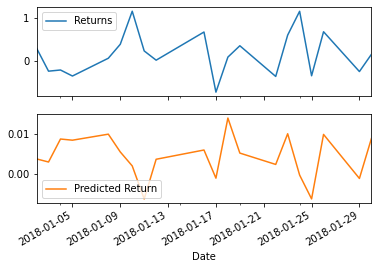

In [156]:
# Plot the first 20 predictions vs the true values
results[:20].plot(subplots=True,xlim=("2018-01-02","2018-01-30"))

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [157]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
out_sample_mse = mean_squared_error(
    results["Returns"],
    results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_sample_rmse = np.sqrt(out_sample_mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4136504970669482


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [158]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe using the model and X_train data:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Returns"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.7059387714146014


# Conclusions

The relatively simlar, and low, RMSE values for the training (in-sample) and testing (out-of-sample) data shows the the model is accurate. Since the testing RMSE is lower than that for training, it can be concluded that the model is not overfitted.